In [23]:
# This file prints the results of algorithms into csv files.

# Stop showing warnings
using Suppressor: @suppress_err

In [24]:
using Clustering
using MultivariateStats
using StatsBase
using CSV
using DataFrames
using CairoMakie
using GaussianMixtures

In [25]:
function ground_true(df_1, df_2)
    a = fill(1,nrow(df_1))
    b = fill(2,nrow(df_2))
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

plot_clusters (generic function with 1 method)

In [26]:
using MLBase
using Hungarian
using LinearAlgebra

In [76]:
# n is the number of cluters
# remember standardize trees for better performance
function kmeans_label(tree, n; seed =:kmpp)  
    # apply kmeans clustering
    # init works like seed of random, Its length should be the same as the number of clusters    
    result = kmeans(tree, n, init = seed);
    return result.assignments
end;


function GMM_label(tree, n; method=:kmeans, kind=:diag)    
    data= tree';
    gmm=GMM(n,Array(data),method=method, kind=kind);
    prob_pos=gmmposterior(gmm,Array(data))[1]
    llpg = gmmposterior(gmm,Array(data))[2]
    llpg_result = map(argmax, eachrow(llpg))
    prob_result = map(argmax, eachrow(prob_pos))
    return Pair(llpg_result, prob_result)
end;

function dbscan_label(tree, radius; min_neighbors = 1, min_cluster_size = 1)   
    result = dbscan(tree, radius,min_neighbors = min_neighbors, min_cluster_size = min_cluster_size)   
    # get only points in clusters
    result = getproperty.(result, :core_indices)
    idx = fill(0,length(tree[1,:]))
    for i in range(1, length(idx))
        if i in result[1]
            idx[i] = 1
        elseif i in result[2]
            idx[i] = 2
        end
    end
    return idx
end;
# Performance Check

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

accuracy (generic function with 1 method)

In [43]:
# Kmeans
function kmeans_matrix(trees, path)
    n = length(trees)
    result = zeros(n, n)
    for i in 1:n
        if i == 1
            continue
        end
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            pred_kmeans = kmeans_label(tree, 2)
            m,x = accuracy(2, gt, pred_kmeans)
            result[i,j] = x
            result[j,i] = x
        end
    end      
    header = Vector(1:n)
    header = string.(header)
    CSV.write(path, DataFrame(result, :auto),header = header);
end

kmeans_matrix (generic function with 1 method)

In [90]:
# GMM
function gmm_matrix(trees, path_prob, path_llpg)
    @suppress_err begin
        n = length(trees)
        result_prob = zeros(n, n)
        result_llpg = zeros(n, n)
        for i in 1:n
            if i == 1
                continue
            end
            for j in  1:(i - 1)
                gt = ground_true(trees[i],trees[j])
                tree = vcat(trees[i],trees[j])
                tree = standardize_tree(tree)
                pred_prob, pred_llpg = GMM_label(tree, 2, method = :split)
                m,x = accuracy(2, gt, pred_prob)
                result_prob[i,j] = x
                result_prob[j,i] = x

                m,x = accuracy(2, gt, pred_llpg)
                result_llpg[i,j] = x
                result_llpg[j,i] = x        
            end
        end 
    
        header = Vector(1:n)
        header = string.(header)
        CSV.write(path_prob, DataFrame(result_prob, :auto),header = header);
        CSV.write(path_llpg, DataFrame(result_llpg, :auto),header = header);
    end
end

gmm_matrix (generic function with 1 method)

In [30]:
# Check begin

In [46]:
trees = []
for i in 1:15
    path = "data/4_taxa_" * string(i) *"_1_100.csv"
    tree = CSV.read(path, DataFrame);
    push!(trees, tree)
end

kmeans_matrix(trees, "data/kmeans_4taxa_100.csv");
gmm_matrix(trees, "data/GMM_prob_4taxa_100.csv", "data/GMM_llpg_4taxa_100.csv");

In [47]:
for j in 1:100
    trees = []
    for i in 1:15
        path = "data/4_taxa_" * string(i) *"_1_1000_" * string(j) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end
    kmeans_matrix(trees, "data/kmeans_4taxa_1000_" * string(j) * ".csv");
    gmm_matrix(trees, "data/GMM_prob_4taxa_1000_" * string(j) * ".csv", "data/GMM_llpg_4taxa_1000_" * string(j) * ".csv");
end

In [48]:
for j in 1:20
    trees = []
    for i in 1:15
        path = "data/4_taxa_" * string(i) *"_1_5000_" * string(j) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end

    kmeans_matrix(trees, "data/kmeans_4taxa_5000_" * string(j) * ".csv");
    gmm_matrix(trees, "data/GMM_prob_4taxa_5000_" * string(j) * ".csv", "data/GMM_llpg_4taxa_5000_" * string(j) * ".csv");
end

In [49]:
for i in 1:15
    trees = []
    for j in 1:6
        path = "data/4_taxa_" *string(i)* "_" * string(j) *"_100.csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end
    
    kmeans_matrix(trees, "data/kmeans_4_tree_" *string(i)* "_100.csv");
    gmm_matrix(trees, "data/GMM_prob_4_tree_" *string(i)* "_100.csv", "data/GMM_llpg_4_tree_" *string(i)* "_100.csv");
end

In [50]:
for k in 1:100
    for i in 1:15
        trees = []
        for j in 1:6
            path = "data/4_taxa_" *string(i)* "_" * string(j) *"_1000_" * string(k) * ".csv"
            tree = CSV.read(path, DataFrame);
            push!(trees, tree)
        end

        kmeans_matrix(trees, "data/kmeans_4_tree_" *string(i)* "_1000_" * string(k) * ".csv");
        gmm_matrix(trees, "data/GMM_prob_4_tree_" *string(i)* "_1000_" * string(k) * ".csv", 
            "data/GMM_llpg_4_tree_" *string(i)* "_1000_" * string(k) * ".csv");
    end
end

In [51]:
for k in 1:20
    for i in 1:15
        trees = []
        for j in 1:6
            path = "data/4_taxa_" *string(i)* "_" * string(j) *"_5000_" * string(k) * ".csv"
            tree = CSV.read(path, DataFrame);
            push!(trees, tree)
        end

        kmeans_matrix(trees, "data/kmeans_4_tree_" *string(i)* "_5000_" * string(k) * ".csv");
        gmm_matrix(trees, "data/GMM_prob_4_tree_" *string(i)* "_5000_" * string(k) * ".csv", 
            "data/GMM_llpg_4_tree_" *string(i)* "_5000_" * string(k) * ".csv");
    end
end

In [52]:
trees = []
for i in 1:15
    path = "data/4_taxa_" * string(i) *"_1_100.csv"
    tree = CSV.read(path, DataFrame);
    push!(trees, tree)
end

In [53]:
# Different topologies and different branch lengths

for i in 1:100
    trees = []
    for j in 1:15      
        path = "data/4_diff_topo_" * string(j) *  "_100_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end
    kmeans_matrix(trees, "data/kmeans_4_diff_topo_100_" *string(i)* ".csv");
    gmm_matrix(trees, "data/GMM_prob_4_topo_100_" *string(i)* ".csv", "data/GMM_llpg_4_topo_100_" *string(i)* ".csv");
end

In [54]:
for i in 1:100
    trees = []
    for j in 1:15      
        path = "data/4_diff_topo_" * string(j) *  "_1000_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end
    kmeans_matrix(trees, "data/kmeans_4_diff_topo_1000_" *string(i)* ".csv");
    gmm_matrix(trees, "data/GMM_prob_4_topo_1000_" *string(i)* ".csv", "data/GMM_llpg_4_topo_1000_" *string(i)* ".csv");
end

In [55]:
for i in 1:100
    trees = []
    for j in 1:15      
        path = "data/4_diff_topo_" * string(j) *  "_5000_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end
    kmeans_matrix(trees, "data/kmeans_4_diff_topo_5000_" *string(i)* ".csv");
    gmm_matrix(trees, "data/GMM_prob_4_topo_5000_" *string(i)* ".csv", "data/GMM_llpg_4_topo_5000_" *string(i)* ".csv");
end

In [95]:
# Different topologies and different branch lengths with 8-taxa

for i in 1:100
    trees = []
    for j in 1:15      
        path = "data/8_diff_topo_" * string(j) *  "_1000_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end
    kmeans_matrix(trees, "data/kmeans_8_diff_topo_1000_" *string(i)* ".csv");
    # gmm_matrix(trees, "data/GMM_prob_8_topo_1000_" *string(i)* ".csv", "data/GMM_llpg_8_topo_1000_" *string(i)* ".csv");
end

In [102]:
for i in 1:100
    trees = []
    for j in 1:15      
        path = "data/8_diff_topo_" * string(j) *  "_5000_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end
    kmeans_matrix(trees, "data/kmeans_8_diff_topo_5000_" *string(i)* ".csv");
    # gmm_matrix(trees, "data/GMM_prob_8_topo_5000_" *string(i)* ".csv", "data/GMM_llpg_8_topo_5000_" *string(i)* ".csv");
end

┌ Info: Initializing GMM, 4 Gaussians diag covariance 127 dimensions using 2000 data points
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:79


K-means converged with 29 iterations (objv = 108141.26162954693)


┌ Info: K-means with 2000 data points using 29 iterations
│ 3.9 data points per parameter
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:141
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\

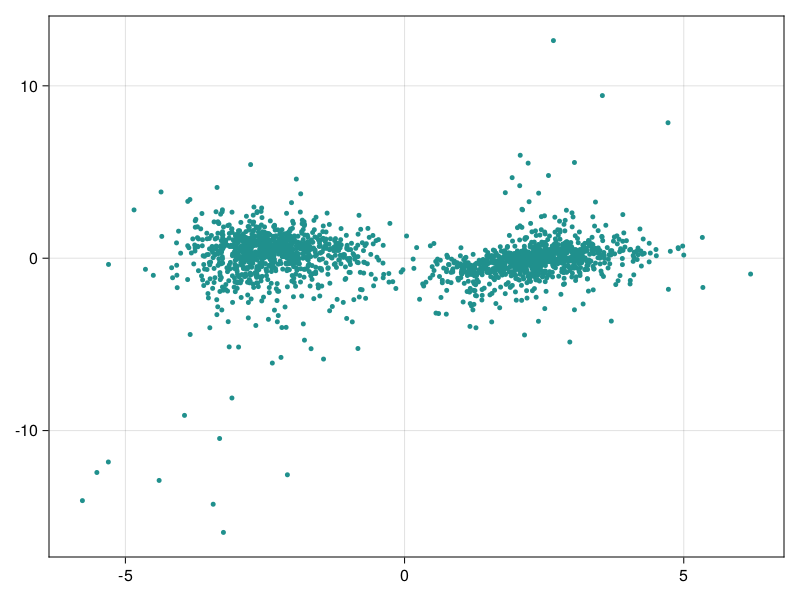

In [101]:
tree1 = CSV.read("data/8_diff_topo_1_1000_12.csv", DataFrame)
tree2 = CSV.read("data/8_diff_topo_14_1000_3.csv", DataFrame)
gt = ground_true(tree1,tree2)
tree = vcat(tree1,tree2)
tree = standardize_tree(tree)
pred_llpg,pred_prob = GMM_label(tree, 4)
m,x = accuracy(2, gt, pred_prob)
plot_clusters(tree,pred_prob)

┌ Info: Initializing GMM, 4 Gaussians diag covariance 127 dimensions using 10000 data points
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:79


K-means converged with 18 iterations (objv = 250811.46966421165)


┌ Info: K-means with 4000 data points using 18 iterations
│ 7.8 data points per parameter
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:141
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 1016 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\

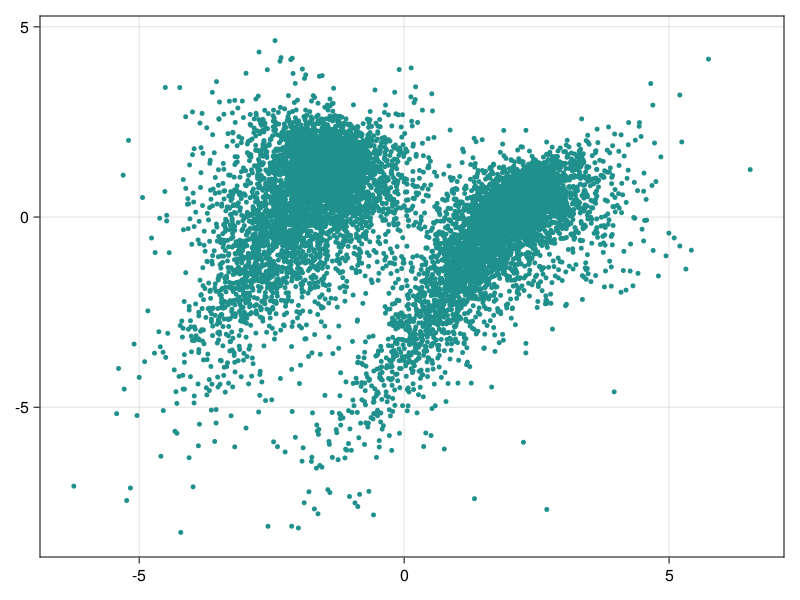

In [98]:
tree1 = CSV.read("data/8_diff_topo_1_5000_12.csv", DataFrame)
tree2 = CSV.read("data/8_diff_topo_7_5000_2.csv", DataFrame)
gt = ground_true(tree1,tree2)
tree = vcat(tree1,tree2)
tree = standardize_tree(tree)
pred_llpg,pred_prob = GMM_label(tree, 4)
m,x = accuracy(2, gt, pred_prob)
plot_clusters(tree,pred_prob)